In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from helper import country_count, butterflies, caterpillars

In [4]:
name = "Green_Bonds"
data = pd.read_csv("input/policy/" + name + ".csv", index_col=0, keep_default_na=False, na_values="")
data = data[np.logical_not(data["ISO2"].isna())] #filter down

In [5]:
years = [year for year in data.columns if len(year) == 5 and year[0] == 'F']

#create temporal
reindexed = data.set_index(["ISO2", "CTS_Code"], inplace = False)
temporal = {}
year = "F2020"
edge_list = []
country = "AF"
subset = reindexed.loc[country]
policy = "GENB_G14"
weight = subset.loc[policy][year] #edge weights are bond values

KeyError: 'AF'

In [21]:
if weight > 0:
    edge = (country, policy, weight) #create edge
    edge_list.append(edge)
temporal[int(year[1:])] = edge_list

NameError: name 'policy' is not defined

### Green Bonds

##### Intro

In [4]:
green_bonds = pd.read_csv("input/policy/Green_Bonds.csv", index_col=0, keep_default_na=False, na_values="")

# Filtered Down to countries
green_bonds = green_bonds[np.logical_not(green_bonds["ISO2"].isna())]

green_bond_country_nodes = green_bonds.ISO2.unique()

# Need to figure out the differences between these bonds
bonds_nodes = green_bonds["CTS_Name"].unique()

Looks likes most years no one invested in bonds. Still very few countries invest in bonds but each year it seems the number increases.

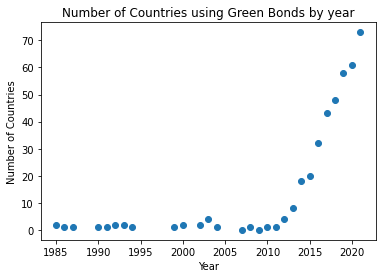

In [13]:
# Get the data
num_countries = green_bonds[green_bonds.columns[12:]].count().to_list()
years = [int(year[1:]) for year in green_bonds.columns[12:]]

# Plot
fig,ax = plt.subplots()
ax.scatter(years, num_countries)
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")

plt.show()

Furthermore we can break the graph down into its two different categories

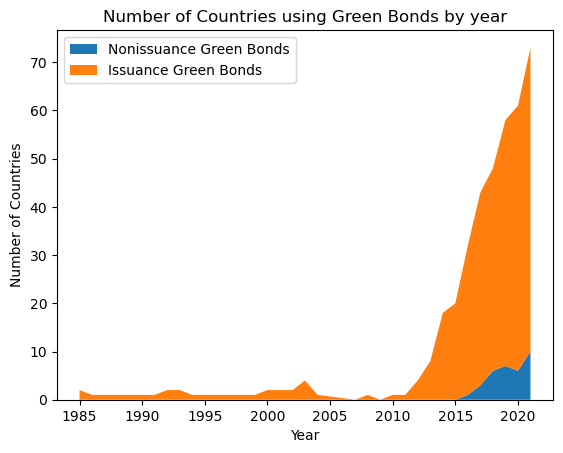

In [24]:
# Get the data
issuances = green_bonds[green_bonds["CTS_Name"] == "Green Bonds Issuances"]

# Calculate Variables
issuance_count = issuances[issuances.columns[12:]].count()
nonissuance_count = num_countries - issuance_count
y = np.vstack([nonissuance_count, issuance_count])

# Plot
fig,ax = plt.subplots()
# Using years var from last cell
ax.stackplot(years, y, labels = ["Nonissuance Green Bonds", "Issuance Green Bonds",])
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")
ax.legend(loc = "upper left")

plt.show()

##### Graph Building

Initializing the nodes in our bipartite graph. Country nodes are on the left and green bond policies are on the right.

In [25]:
B = nx.Graph()
B.add_nodes_from(green_bond_country_nodes, bipartite=0)
B.add_nodes_from(bonds_nodes, bipartite=1)

We are creating the edge_lists for every single year. This can allow for quick creation of graphs for any specific year.

In [26]:
green_bonds_temp = green_bonds.set_index(["ISO2", "CTS_Name"], inplace = False)
dict = {}
for year in green_bonds.columns[12:]: #create edge lists for each year
    edge_list = []
    for country in green_bond_country_nodes: #find every country-bond combo
        subset = green_bonds_temp.loc[country]
        for bond in subset.index: #bond
            weight = subset.loc[bond][year] #edge weights are bond values
            if weight > 0:
                edge = (country, bond, weight) #create edge
                edge_list.append(edge)
    dict[int(year[1:])] = edge_list

Let's create a graph for 2015 and see what it looks like:

In [27]:
B.remove_edges_from(B.edges)
B.add_weighted_edges_from(dict[2021])
print("Number of Edges:", B.number_of_edges())
print("Number of Possible Edges:", len(green_bond_country_nodes) * len(bonds_nodes))

Number of Edges: 73
Number of Possible Edges: 152


Let's also create some global measures for our graphs. First, let's find the number of countries implementing any policies at all in a given year. Then let's create an algorithm for counting the number of butterflies and caterpillars. We define a caterpillar as a pair of nodes in each bipartite which have 3/4 of the potential edges between them. A butterfly is a pari of nodes in each bipartite which have 4/4 potential edges. We require two helper methods for iterating through pairs of policy nodes. All code can be found in helper.py but the results are printed below.

In [28]:
print("Country Count:", country_count(B, green_bond_country_nodes))
print("Butterflies:", butterflies(B))
print("Caterpillars:", caterpillars(B))

Country Count: 63
Butterflies: 45
Caterpillars: 710


##### Analysis

Temporal graph creation:

In [29]:
results = []
for year in years[22:]:
    B.remove_edges_from(B.edges)
    B.add_weighted_edges_from(dict[year])
    countries = country_count(B, green_bond_country_nodes) #participating countries
    results.append({"Year": year, "Countries": countries, "Edges": B.number_of_edges(), "Butterflies": butterflies(B),\
                    "Caterpillars": caterpillars(B), "Ratio": 4 * butterflies(B) / caterpillars(B)})
bonds_time = pd.DataFrame(results)

Text(0.5, 1.0, 'Butterfly Caterpillar Ratio for Green Bonds Graph')

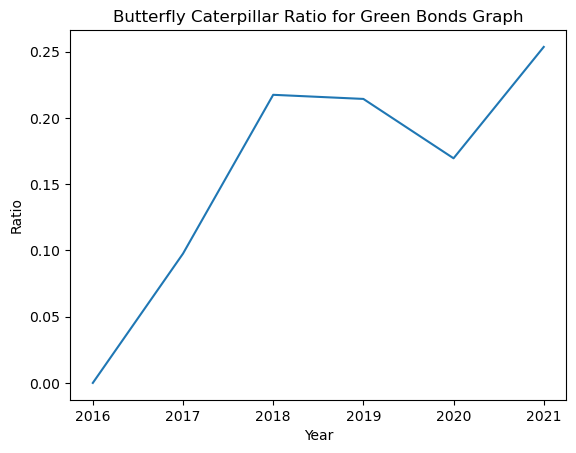

In [30]:
plt.plot(bonds_time.Year, bonds_time.Ratio)
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Butterfly Caterpillar Ratio for Green Bonds Graph')

Things to implement temporally: (loop through every year, show how these change)
- number of nodes (remove those without any edges)
- number of edges (weighted)
- number of trianges -> metamorphis coefficient
- change point detection
- any other correlation measures

Node based metrics:
- harmonic, closeness, degree, & eigenvector centralities
- you can show how it changes over time

Clustering:
- find out how to cluster bipartite graphs
- change point detection

# Fossil Fuel Subsidies

##### Data Import
Note that we need to keep values titled "NA" because that's Namibia's ISO2 code. Also, Kosovo doesn't have an ISO3 so we can't use that.

In [31]:
subsidy = pd.read_csv('input/policy/Fossil_Fuel_Subsidies.csv', index_col=0, keep_default_na=False, na_values="")
subsidy.head(3)

,Country,ISO2,ISO3,Indicator,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Unit,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,F2023,F2024,F2025
ObjectId,,,,,,,,,,,,,,,,,,,,
1,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Coal,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTEC,Explicit; Coal,"Environment, Climate Change, Government Policy...",Percent of GDP,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Coal,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTEC,Explicit; Coal,"Environment, Climate Change, Government Policy...",US Dollars,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Electricity,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTET,Explicit; Electricity,"Environment, Climate Change, Government Policy...",Percent of GDP,0.0,0.0,0.0,0.083287,0.375834,0.075661,0.252216,0.247982,0.270226,0.271118,0.245831


In [32]:
country_nodes = subsidy.ISO2.unique()
policy_nodes = subsidy.CTS_Code.unique()
print("Number of Countries:", len(country_nodes))
print("Number of Subsidies:", len(policy_nodes))

Number of Countries: 197
Number of Subsidies: 21


Another question would be how do we create groups of subsidies. We'll call the fossil fuel subsidy bi-partite graph S.

In [33]:
S = nx.Graph()
S.add_nodes_from(country_nodes, bipartite=0)
S.add_nodes_from(policy_nodes, bipartite=1)

Note that the following countries do not have the Petroleum field. We'll simply not draw edges.

In [34]:
full = set(subsidy[subsidy.ISO2 == "AF"].CTS_Name)
subsidy_sub = subsidy[subsidy.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = subsidy_sub[subsidy_sub.ISO2 == country]
    if len(subset) < 21:
        print(country, len(subset))
        partial = set(subsidy[subsidy.ISO2 == country].CTS_Name)
        print(full - partial)

AI 20
{'Implicit; Petroleum'}
MH 20
{'Implicit; Petroleum'}
PW 20
{'Implicit; Petroleum'}
SM 20
{'Implicit; Petroleum'}
TV 20
{'Implicit; Petroleum'}


Loop through every country/policy combination and add an edge if the value for specified year was greater than 0.

In [35]:
df_temp = subsidy[subsidy.Unit == "Percent of GDP"]
df_temp.set_index(["ISO2", "CTS_Code"], inplace = True)
dict = {}

for year in subsidy.columns[9:]:
    edge_list = []
    for country in country_nodes:
        subset = df_temp.loc[country]
        for policy_code in subset.index:
            weight = subset.loc[policy_code][year]
            if weight > 0:
                edge = (country, policy_code, weight)
                edge_list.append(edge)
    dict[int(year[1:])] = edge_list

S.add_weighted_edges_from(edge_list)

In [36]:
print("Number of Edges:", S.number_of_edges())
print("Number of Possible Edges:", len(country_nodes) * len(policy_nodes))

Number of Edges: 2958
Number of Possible Edges: 4137


### Analysis

In [ ]:
results = []
years = [int(year[1:]) for year in subsidy.columns[9:]]
for year in years:
    S.remove_edges_from(S.edges)
    S.add_weighted_edges_from(dict[year])
    results.append({"Year": year, "Countries": country_count(S, country_nodes), "Edges": S.number_of_edges(), "Butterflies": butterflies(S),\
                    "Caterpillars": caterpillars(S), "Ratio": 4 * butterflies(S) / caterpillars(S)})
subsidy_time = pd.DataFrame(results)

In [ ]:
subsidy_time

,Year,Countries,Edges,Butterflies,Caterpillars,Ratio
0,2015,188,2625,1042378,5239483,0.795787
1,2016,188,2638,1047575,5273580,0.794584
2,2017,189,2704,1115783,5582115,0.799541
3,2018,190,2825,1268430,6215032,0.816363
4,2019,191,3034,1584275,7442802,0.851440
5,2020,190,2859,1320783,6413289,0.823779
6,2021,191,2870,1336347,6467542,0.826495
7,2022,191,2877,1341583,6488692,0.827028
8,2023,191,2915,1399480,6711951,0.834023
9,2024,191,2914,1404496,6723779,0.835540


Text(0.5, 1.0, 'Butterfly Caterpillar Ratio for Fossil Fuel Subsidy Graph')

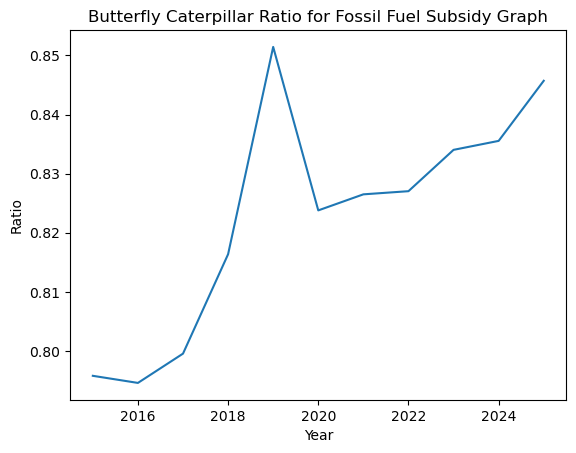

In [ ]:
plt.plot(subsidy_time.Year, subsidy_time.Ratio)
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Butterfly Caterpillar Ratio for Fossil Fuel Subsidy Graph')

### Change Point Detection

NEED TO FINISH

### Clustering

NEED TO FINSIH

# Green Bonds

### Intro

In [6]:
green_bonds = pd.read_csv("input/policy/Green_Bonds.csv", index_col=0, keep_default_na=False, na_values="")

# Filtered Down to countries
green_bonds = green_bonds[np.logical_not(green_bonds["ISO2"].isna())]

green_bond_country_nodes = green_bonds.ISO2.unique()
# Need to figure out the differences between these bonds
bonds_nodes = green_bonds["CTS_Name"].unique()

Looks likes most years no one invested in bonds. Still very few countries invest in bonds but each year it seems the number increases.

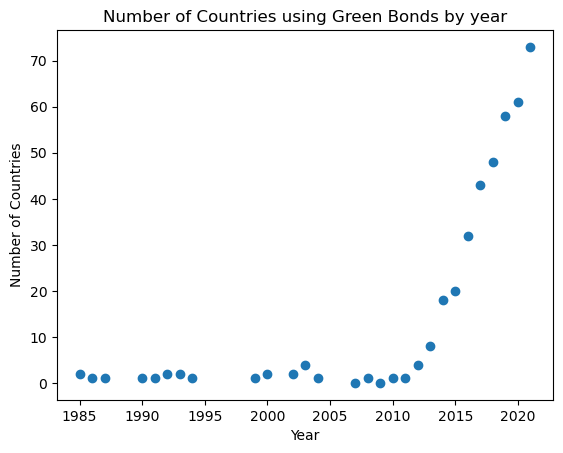

In [7]:
# Get the data
num_countries = green_bonds[green_bonds.columns[12:]].count().to_list()
years = [int(year[1:]) for year in green_bonds.columns[12:]]

# Plot
fig,ax = plt.subplots()
ax.scatter(years, num_countries)
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")

plt.show()

Furthermore we can break the graph down into its two different categories

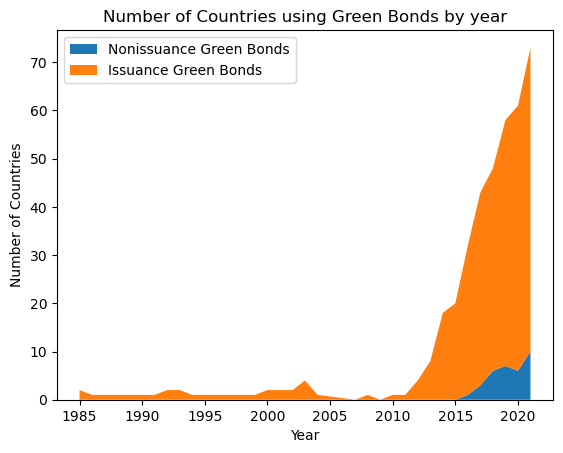

In [39]:
# Get the data
issuances = green_bonds[green_bonds["CTS_Name"] == "Green Bonds Issuances"]


# Calculate Variables
issuance_count = issuances[issuances.columns[12:]].count()
nonissuance_count = num_countries - issuance_count
y = np.vstack([nonissuance_count, issuance_count])

# Plot
fig,ax = plt.subplots()
# Using years var from last cell
ax.stackplot(years, y, labels = ["Nonissuance Green Bonds", "Issuance Green Bonds",])
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")
ax.legend(loc = "upper left")

plt.show()

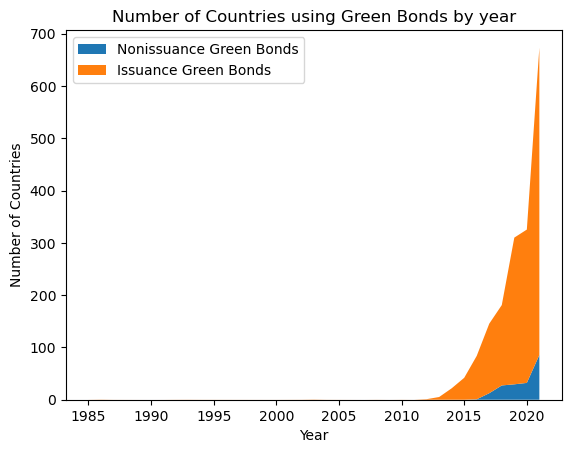

In [40]:
# Get the data
issuances = green_bonds[green_bonds["CTS_Name"] == "Green Bonds Issuances"]
nonissuances = green_bonds[green_bonds["CTS_Name"] == "Green Bonds"]

# Calculate Variables
issuance_money = issuances[issuances.columns[12:]].fillna(0).sum()
nonissuance_money = nonissuances[nonissuances.columns[12:]].fillna(0).sum()
y = np.vstack([nonissuance_money, issuance_money])

# Plot
fig,ax = plt.subplots()
# Using years var from last cell
ax.stackplot(years, y, labels = ["Nonissuance Green Bonds", "Issuance Green Bonds",])
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")
ax.legend(loc = "upper left")

plt.show()

### Graph Building

Initializing the nodes in our bipartite graph. Country nodes are on the left and green bond policies are on the right.

In [8]:
B = nx.Graph()
B.add_nodes_from(green_bond_country_nodes, bipartite=0)
B.add_nodes_from(bonds_nodes, bipartite=1)

We are creating the edge_lists for every single year. This can allow for quick creation of graphs for any specific year.

In [9]:
green_bonds_temp = green_bonds.set_index(["ISO2", "CTS_Name"], inplace = False)
green_bond_years = []
green_bond_dict = {}

for year in green_bonds.columns[12:]: #create edge lists for each year
    edge_list = []
    for country in green_bond_country_nodes: #find every country-bond combo
        subset = green_bonds_temp.loc[country]
        for bond in subset.index: #bond
            weight = subset.loc[bond][year] #edge weights are bond values
            if weight > 0:
                edge = (country, bond, weight) #create edge
                edge_list.append(edge)
    # Take out years with no policies
    if not (len(edge_list) == 0):
        green_bond_years.append(int(year[1:]))
        green_bond_dict[int(year[1:])] = edge_list



Let's create a graph for 2015 and see what it looks like:

In [10]:
B.remove_edges_from(B.edges)
B.add_weighted_edges_from(green_bond_dict[2015])
print("Number of Edges:", B.number_of_edges())
print("Number of Possible Edges:", len(green_bond_country_nodes) * len(bonds_nodes))

Number of Edges: 20
Number of Possible Edges: 152


Let's also create a method to see the number of countries implementing any policies at all:

In [18]:
def country_count(B, country_nodes):
    deg_policy, deg_country = bipartite.degrees(B, country_nodes)
    sum = 0
    for c, d in deg_country:
        if d > 0:
            sum += 1
    return sum
print("Participating Countries:", country_count(B, green_bond_country_nodes))

Participating Countries: 20


### Change Point Detection:

In [12]:
windowSize = 6


def change_point_detection(windowSize, G, years, edge_dict):

    dict_signatures = {}
    for year in years:
        G.remove_edges_from(G.edges)
        G.add_weighted_edges_from(edge_dict[year])

        # Create the signless Laplacian but found the normalized laplacian to be better
        # A = nx.adjacency_matrix(B)
        # D = np.diag(nx.laplacian_matrix(B).diagonal())

        laplacian = nx.normalized_laplacian_matrix(G).toarray()
        singular_values = np.linalg.svd(laplacian)[1]
        l2_norm = np.linalg.norm(singular_values, ord = 2)
        
        
        norm_singluar_values = singular_values / l2_norm

        dict_signatures[year] = norm_singluar_values

    

    window_dicts = {}
    for i in range(len(years) - windowSize):
        year_subset = years[i:i+windowSize]

        # Choose one random signature to start our weights_avg
        weights_avg = np.zeros(dict_signatures[2018].shape)

        for year in year_subset:
            weights_avg += dict_signatures[year] * (1/windowSize)

        window_dicts[years[windowSize + i]] = weights_avg / np.linalg.norm(weights_avg, ord = 2)


    Z_list = []
    year_list = []

    for year in window_dicts.keys():
        baseline = window_dicts[year]
        single_year = dict_signatures[year]
        Z = 1-np.transpose(single_year) @ baseline

        Z_list.append(Z)
        year_list.append(year)

    return [Z_list, year_list]
    
Z_list, year_list = change_point_detection(windowSize, B, green_bond_years, green_bond_dict)

    


Traceback (most recent call last):
  File "/Users/robert/opt/miniconda3/envs/climate_policy_network_sci/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined
<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Successfully was able to show that the biggest change was in 2010s. Need to update method to take out laplacians that are 0, but I feel like this is important information.

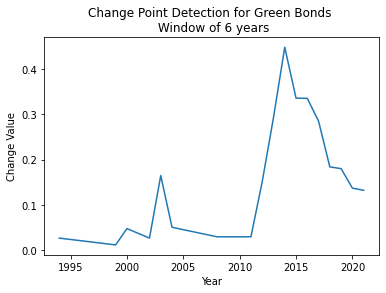

In [23]:
fig,ax = plt.subplots()
# Using years var from last cell
ax.plot(year_list, Z_list)
ax.set_title("Change Point Detection for Green Bonds \n Window of 6 years")
ax.set_ylabel("Change Value")
ax.set_xlabel("Year")

plt.show()


### Clustering

This code maps each policy and country to its corresponding numerical id that will be used in the BINE code

In [50]:
green_bond_node_mapping = {}

# Mapping for contries
i = 0
for country in green_bonds["ISO2"].unique():
    green_bond_node_mapping[country] = f"u{i}"
    i += 1

# Mapping for policies
j = 0
for policy in green_bonds["CTS_Name"].unique():
    green_bond_node_mapping[policy] = f"i{j}"
    j += 1

# Reverses the mapping to be id to name
inv_green_bond_mapping = {v: k for k, v in green_bond_node_mapping.items()}

There are 2 parts to the next code block:

1. First, we create edgelists for each graph in a format the BINE algorithm can read
1. Second we read each edgelist and create a command to run in the terminal that obtains the BINE embeddings

Note: The reason we have to write these commands to a new text file is because we need to run an old version of python for BINE algorithm to work.

In [51]:
import os

# Create graphs BINE can read
for year in green_bond_years:
    B.remove_edges_from(B.edges)
    B.add_weighted_edges_from(green_bond_dict[year])

    # Relabels our graph from name to id to work on BINE code
    B_integer = nx.relabel_nodes(B, green_bond_node_mapping)

    fileName = f"BiNE-master/data/greenbonds/greenbonds_{year}_edgelist.dat"
    nx.write_weighted_edgelist(B_integer, fileName, delimiter = "\t")

# Create commands to run BINE file.
with open("Green_bond_commands.txt", "w") as f:
    for year in green_bond_years:
        command = f"python train.py --train-data ../data/greenbonds/greenbonds_{year}_edgelist.dat --lam 0.025 --d 10 --max-iter 100 --large 2 --vectors-u ../data/greenbonds/vectors_u_{year}.dat --vectors-v ../data/greenbonds/vectors_v_{year}.dat &&"
        f.write(command)


Now that we have feature representations of our countries we can complete a cluster analysis with them. 

Between the code block above and the code block below, we must run the commands file to obtain all the BINE embeddings. After we obtain the BINE embeddings, we then can read them into a pandas file for simple analysis.

In [52]:
bine_embeddings_bonds_dict = {}

for year in green_bond_years:

    out_mat = []
    cols = []
    countries = []

    # This code is only opening the BINE embeddings for a specific year.
    with open(f"BiNE-master/data/greenbonds/vectors_u_{year}.dat", "r") as f:
        for line in f:
            data = line.split()

            # Parses what country our embedding is of.
            countries.append(data[0])

            # Obtains the embedding for country
            values = [float(elt) for elt in data[1:]]

            # Reshapes the embedding
            col = np.array(values).reshape((len(values),1))
            cols.append(col)

        out_mat = np.concatenate(cols, axis =1)

    # Changes ids of countries to their actual country names
    country_names = [inv_green_bond_mapping[country] for country in countries]

    pandas_bine_embeddings_bonds = pd.DataFrame(out_mat, columns = country_names)

    bine_embeddings_bonds_dict[year] = pandas_bine_embeddings_bonds

Lets view what each embedding looks like for each country

In [53]:
pandas_bine_embeddings_bonds = bine_embeddings_bonds_dict[2021]
pandas_bine_embeddings_bonds

,TW,TH,UA,GB,SG,SK,ZA,ES,SE,CH,...,GG,HU,FI,FR,GE,NZ,LI,IS,IN,PH
0,0.360465,0.191613,0.374990,0.366984,0.326026,0.019438,0.300085,0.437258,0.177176,0.275612,...,0.435629,0.174318,0.399621,0.825742,0.219181,0.611400,0.074630,0.589186,0.217322,0.411551
1,0.444382,0.359464,0.514755,0.412164,0.370195,0.099489,0.357959,0.582137,0.595769,0.102700,...,0.095939,0.136924,0.089223,0.473211,0.300738,0.110892,0.141813,0.132007,0.531118,0.006947
2,0.291791,0.462747,0.215559,0.288005,0.097702,0.224796,0.267987,0.138990,0.152244,0.186718,...,0.515764,0.472511,0.494365,0.488093,0.216870,0.022645,0.310646,0.056521,0.129541,0.341459
3,0.189160,0.089318,0.445759,0.600941,0.465359,0.465045,0.389689,0.474116,0.543860,0.312516,...,0.286948,0.119323,0.113977,0.212222,0.467627,0.501111,0.408074,0.236087,0.150022,0.477939
4,0.202341,0.265240,0.179494,0.730669,0.125221,0.205035,0.333070,0.624475,0.244820,0.195991,...,0.083416,0.247145,0.507063,0.302105,0.163908,0.388923,0.173432,0.147939,0.114294,0.468409
5,0.297113,0.009597,0.318254,0.596196,0.079796,0.483082,0.098642,0.412613,0.248311,0.400416,...,0.258407,0.056514,0.177707,0.391584,0.132818,0.110197,0.199281,0.088239,0.154224,0.477313
6,0.248897,0.310248,0.443670,0.543106,0.305086,0.258153,0.379340,0.368601,0.623421,0.230195,...,0.291302,0.342805,0.436529,0.635330,0.569585,0.234954,0.377983,0.355192,0.393546,0.174080
7,0.421303,0.441547,0.237482,0.344165,0.560335,0.330991,0.323784,0.249185,0.372659,0.531087,...,0.511372,0.451836,0.435732,0.437856,0.027417,0.240800,0.423283,0.310697,0.439654,0.098117
8,0.406833,0.429686,0.178031,0.429180,0.073603,0.373213,0.424688,0.213430,0.231858,0.396977,...,0.223349,0.445486,0.224320,0.566230,0.461801,0.062713,0.322293,0.161961,0.286096,0.017653
9,0.277664,0.351197,0.117629,0.473230,0.547377,0.424705,0.185385,0.348375,0.333194,0.414905,...,0.114262,0.458137,0.109560,0.326086,0.259462,0.379224,0.517734,0.591490,0.596646,0.138657


Before we officially cluster, I will use the Shilloute Score to see how many cluster we should use in our K-Means clustering

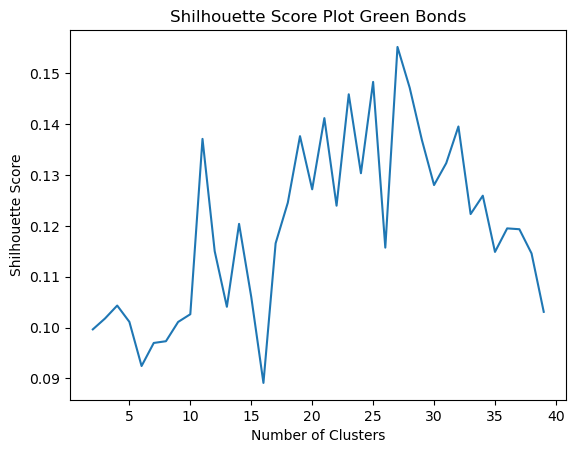

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# First we obtain the clusterings on the BINE embeddings using K

X = pandas_bine_embeddings_bonds.transpose()

silscore_x = []
silscore_y = []

for k in range(2,40):
    clusterer = KMeans(n_clusters = k, random_state=10, n_init=10)
    clustering= clusterer.fit(X)
    score = silhouette_score(X, clustering.labels_)

    silscore_x.append(k)
    silscore_y.append(score)


fig, ax = plt.subplots()
scatter = ax.plot(silscore_x, silscore_y)
ax.set_title("Shilhouette Score Plot Green Bonds")
ax.set_ylabel("Shilhouette Score")
ax.set_xlabel("Number of Clusters")
plt.show()



From the above shilhouette scores it seems that the best number of clusters is 22, which means there will be about 3 countries per cluster. The clusters will then be pretty small. This also might be because the greenbonds is a pretty sparse dataset.

Now that we have examined a good clustering of the data, we can visualize our clutering. First we will try the optimal 22 clusters and then try a simplier one like 3 clusters.

As a baseline we can also look at the clustering if we just look at the column of each adjacency matrix

In [55]:
columns = []
B.remove_edges_from(B.edges)
B.add_weighted_edges_from(green_bond_dict[2021])
countries_in_green_bonds = []

for node in B.nodes(data=True):

    # obtains nodes in partition 0, which is the country nodes
    if node[1]["bipartite"] == 0:

        col = np.zeros((2,1))
        # Obtains list of all edges that country is in
        for connect in B.edges(node[0], data = True):
            # Gets weight for Green Bonds Issuances
            if connect[1] == "Green Bonds Issuances":
                col[0,0] = connect[2]["weight"]
            # Gets weight for NonGreen Bonds Issuances
            else:
                col[1,0] = connect[2]["weight"]

        if not (col.sum() == 0):
            countries_in_green_bonds.append(node[0])
            columns.append(col)

sorted_indicies = np.argsort(np.array(countries_in_green_bonds))
graph_data = np.concatenate(columns, axis = 1)[:,sorted_indicies]

First we can make the clustering for the year 2021 using the normal clusters

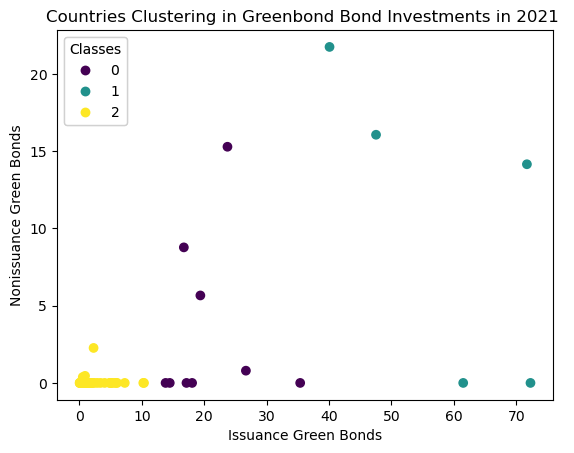

In [56]:
clustering_b = KMeans(n_clusters = 3, n_init= 10).fit(graph_data.transpose())
# clustering.labels_

fig,ax = plt.subplots()
# Using years var from last cell
scatter = ax.scatter(graph_data[0, :], graph_data[1,:], c = clustering_b.labels_)
ax.set_title("Countries Clustering in Greenbond Bond Investments in 2021 ")
ax.set_ylabel("Nonissuance Green Bonds")
ax.set_xlabel("Issuance Green Bonds")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)

plt.show()

The following is helper code to get a mapping between the country name abbreviations and the full country name

In [57]:
i = 0 
country_abv_to_full = {}
    
country_ab = green_bonds["ISO2"].unique()
country_list = green_bonds["Country"].unique()

for i in range(len(country_ab)):
    country_abv_to_full[country_ab[i]] = country_list[i]


This code takes the labels of the countries

In [58]:
for abv in np.array(country_names)[clustering.labels_[np.argsort(np.array(country_names))] == 38]:
    print(country_abv_to_full[abv])

Italy


In [59]:
bine_labels = np.array(clustering.labels_)[np.argsort(np.array(country_names))]
sorted_countries = np.array(country_names)[np.argsort(np.array(country_names))]
for abv in sorted_countries[bine_labels == 0]:
    print(country_abv_to_full[abv])

Ireland
China, P.R.: Macao
Norway


In [60]:
relabeled_bine_labels = np.zeros(bine_labels.shape)

i = 0
for label in bine_labels:
    if label ==1 :
        relabeled_bine_labels[i] = 0
    elif label == 0:
        relabeled_bine_labels[i] = 1
    else:
        relabeled_bine_labels[i] =2 

    i+=1

for abv in sorted_countries[relabeled_bine_labels == 0]:
    print(country_abv_to_full[abv])


Japan


### Largest Change in Countries

Now that we have completed change point detection, we want to be able to analysis what caused the large change between years. For this we need to analysis how much a country changed between years. We can easily accomplish this by calculating the similarity between policies for countries in a range of years and find which country had the largest change between years. We don't use the bine embeddings of countries here because we don't have bine embeddings for every country. A country that is not implementing a policy will not have an embedding which causes challenges when calculating the change over time.

In [61]:
yearly_adjacency_dict = {}
sorted_greenbond_countries = np.sort(green_bond_country_nodes)

for year in green_bond_years:
    columns = []
    B.remove_edges_from(B.edges)
    B.add_weighted_edges_from(green_bond_dict[year])
    countries_in_green_bonds = []

    for node in B.nodes(data=True):

        # obtains nodes in partition 0, which is the country nodes
        if node[1]["bipartite"] == 0:

            col = np.zeros((2,1))
            # Obtains list of all edges that country is in
            for connect in B.edges(node[0], data = True):
                # Gets weight for Green Bonds Issuances
                if connect[1] == "Green Bonds Issuances":
                    col[0,0] = connect[2]["weight"]
                # Gets weight for NonGreen Bonds Issuances
                else:
                    col[1,0] = connect[2]["weight"]

            countries_in_green_bonds.append(node[0])
            columns.append(col)

    sorted_indicies = np.argsort(np.array(countries_in_green_bonds))
    graph_data = np.concatenate(columns, axis = 1)[:,sorted_indicies]
    

    yearly_adjacency_dict[year] = graph_data



Now that we have a dataframe that stores all of the matrices, we can now compute the differences between years with a given window size.

In [62]:
window_dicts = {}

def country_difference(windowSize, adjacency_dict, years, countries):
    
    window_dicts = {}
    for i in range(len(years) - windowSize):
        year_subset = years[i:i+windowSize]

        # Choose one random signature to start our weights_avg
        weights_avg = np.zeros(adjacency_dict[years[0]].shape)

        for year in year_subset:
            weights_avg += adjacency_dict[year] * (1/windowSize)

        window_dicts[years[windowSize + i]] = weights_avg / np.linalg.norm(weights_avg, ord = 2)


    country_change = {}

    for year in window_dicts.keys():
        baseline = window_dicts[year]
        single_year = adjacency_dict[year]
        
        change = np.power(baseline - single_year, 2).sum(axis = 0)
        sort_indices = np.argsort(change)[::-1]
        info = (countries[sort_indices], change[sort_indices])

        country_change[year] = info

    return country_change


country_change = country_difference(6,yearly_adjacency_dict, green_bond_years, sorted_greenbond_countries)


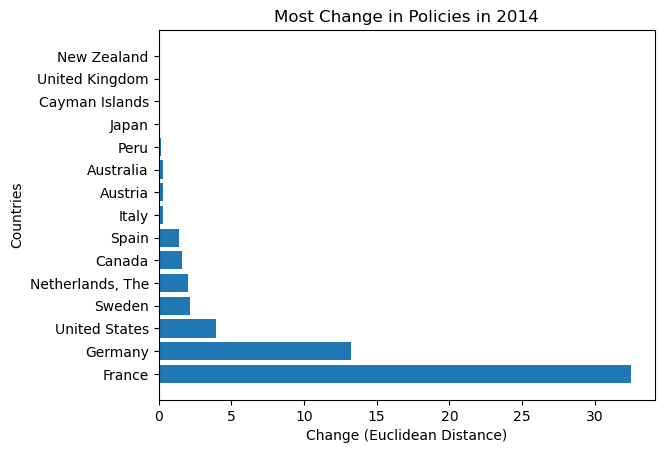

In [63]:
year = 2014

countryOrder_abv, changeScore = country_change[year]

countryOrder = [country_abv_to_full[country] for country in countryOrder_abv[changeScore > 0]]
changeScore = changeScore[changeScore > 0]

fig, ax = plt.subplots()
ax.barh(countryOrder[:15], changeScore[:15])
ax.set_title(f"Most Change in Policies in {year}")
ax.set_ylabel("Countries")
ax.set_xlabel("Change (Euclidean Distance)")
plt.show()

In [64]:
countryOrder_abv

array(['FR', 'DE', 'US', 'SE', 'NL', 'CA', 'ES', 'IT', 'AT', 'AU', 'PE',
       'JP', 'KY', 'GB', 'NZ', 'CN', 'KR', 'VG', 'ZA', 'NO', 'IE', 'PA',
       'PH', 'CR', 'GE', 'SC', 'SG', 'FJ', 'FI', 'SI', 'EG', 'EE', 'DK',
       'SK', 'CZ', 'CO', 'GR', 'TH', 'CL', 'CH', 'TR', 'BR', 'BM', 'BE',
       'BD', 'TW', 'UA', 'AR', 'GG', 'HU', 'HK', 'PK', 'PL', 'PT', 'NG',
       'NA', 'MY', 'MX', 'MU', 'MO', 'MH', 'MA', 'LV', 'LU', 'LT', 'LI',
       'RO', 'VN', 'RS', 'JE', 'RU', 'IS', 'IN', 'IL', 'ID', 'AE'],
      dtype=object)

In [65]:
green_bonds[green_bonds["ISO2"] == "CN"][["ISO2","Indicator","F2012","F2013", "F2014", "F2015", "F2016", "F2017"]]


,ISO2,Indicator,F2012,F2013,F2014,F2015,F2016,F2017
ObjectId,,,,,,,,
17,CN,Green Bond Issuances by Country,NaN,NaN,0.156816,0.994109,31.30316,31.25946


In [66]:
green_bonds[green_bonds["ISO2"] == "CN"][["ISO2","Indicator","F2012","F2013", "F2014", "F2015", "F2016", "F2017"]]

,ISO2,Indicator,F2012,F2013,F2014,F2015,F2016,F2017
ObjectId,,,,,,,,
17,CN,Green Bond Issuances by Country,NaN,NaN,0.156816,0.994109,31.30316,31.25946


In [67]:
green_bonds[green_bonds["ISO2"] == "US"][["ISO2","Indicator","F2012","F2013", "F2014", "F2015"]]

,ISO2,Indicator,F2012,F2013,F2014,F2015
ObjectId,,,,,,
96,US,Green Bond Issuances by Country,NaN,0.5,2.1438,8.262994


# Environmental Taxes

First lets load in the data and take a quick peak.  The final table is a table about how many measures each country implements.

In [68]:
taxes = pd.read_csv("input/policy/Environmental_Taxes.csv", index_col=0, keep_default_na=False, na_values="")

num_countries = len(taxes["Country"].unique())
print(f"There are {num_countries} unique countries that are implementing environmental taxes")
print("Each country typically reports 10 different measures, but there are a few that report less than 10 measures")

taxes.Country.value_counts().value_counts()

There are 124 unique countries that are implementing environmental taxes
Each country typically reports 10 different measures, but there are a few that report less than 10 measures


count
10    118
8       3
6       1
5       1
4       1
Name: count, dtype: int64

In [69]:
tax_country_nodes = taxes.ISO2.unique()
tax_policy_nodes = taxes.CTS_Code.unique()
print("Number of Countries:", len(country_nodes))
print("Number of Subsidies:", len(policy_nodes))

T = nx.Graph()
T.add_nodes_from(country_nodes, bipartite=0)
T.add_nodes_from(policy_nodes, bipartite=1)

Number of Countries: 197
Number of Subsidies: 21


In [70]:
tax_edge_dict = {}

taxes_sub = taxes[taxes.Unit == "Percent of GDP"]
for year in taxes_sub.columns[10:]:
    edge_list = []
    for country in tax_country_nodes:
        subset = taxes_sub[taxes_sub.ISO2 == country]
        for policy in tax_policy_nodes:
            weight = subset[subset.CTS_Code == policy][year].values
            if weight > 0:
                edge = (country, policy, weight[0])
                edge_list.append(edge)
    tax_edge_dict[int(year[1:])] = edge_list

/var/folders/19/6hz5c0tn7g317trnm9tqf_900000gn/T/ipykernel_7817/1921600594.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight > 0:


In [71]:
T.add_weighted_edges_from(edges)
print("Number of Edges:", T.number_of_edges())
print("Number of Possible Edges:", len(country_nodes) * len(policy_nodes))

NameError: name 'edges' is not defined

### Analysis

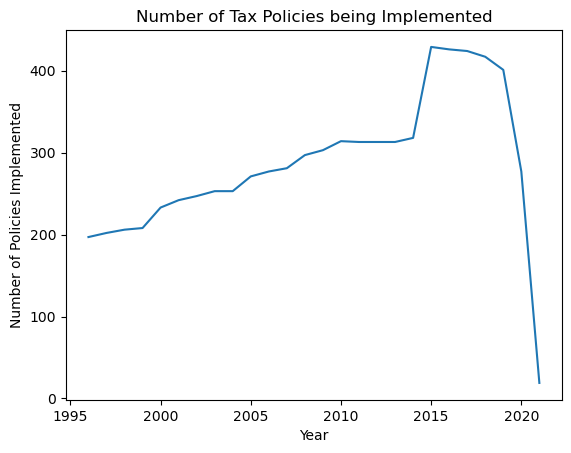

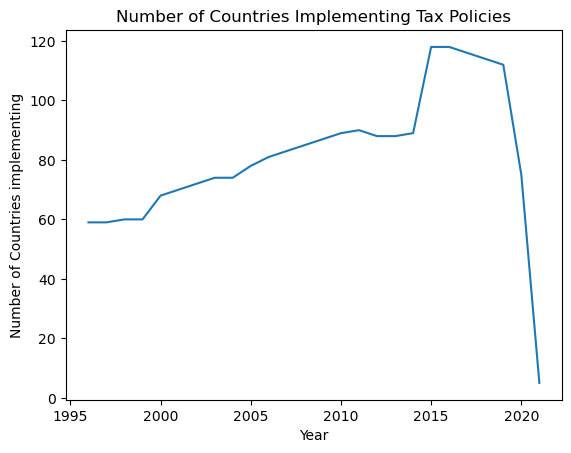

In [72]:
taxes_no_zeros = taxes_sub.fillna(0)
graph_years = []
graph_count = []
graph_country_count = []

for year in taxes_sub.columns[10:]:
    implement_count = (taxes_no_zeros[year] > 0).sum()

    b = taxes_no_zeros[year] > 0
    countries = taxes[taxes["Unit"] == "Percent of GDP"]["ISO2"]
    num_countries = len(countries[b].unique())

    graph_years.append(int(year[1:]))
    graph_count.append(implement_count)
    graph_country_count.append(num_countries)

# Plot
fig,ax = plt.subplots()
# Using years var from last cell
ax.plot(graph_years, graph_count)
ax.set_title("Number of Tax Policies being Implemented")
ax.set_ylabel("Number of Policies Implemented")
ax.set_xlabel("Year")

plt.show()

# Plot
fig,ax = plt.subplots()
# Using years var from last cell
ax.plot(graph_years, graph_country_count)
ax.set_title("Number of Countries Implementing Tax Policies")
ax.set_ylabel("Number of Countries implementing")
ax.set_xlabel("Year")

plt.show()


Another simple analysis I want to have is how many countries are implementing tax policies each year.

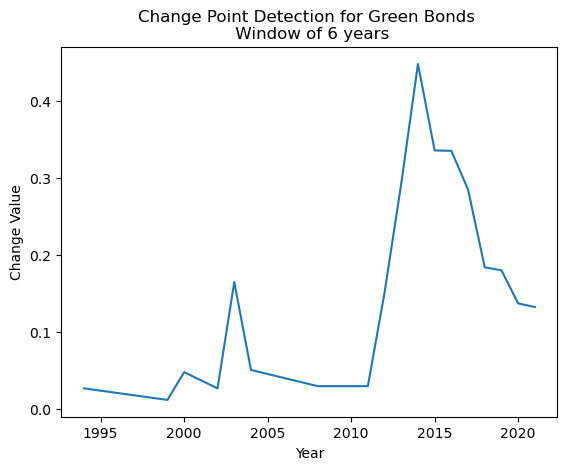

In [73]:
fig,ax = plt.subplots()
# Using years var from last cell
ax.plot(year_list, Z_list)
ax.set_title("Change Point Detection for Green Bonds \n Window of 6 years")
ax.set_ylabel("Change Value")
ax.set_xlabel("Year")

plt.show()

### Change Point 

<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


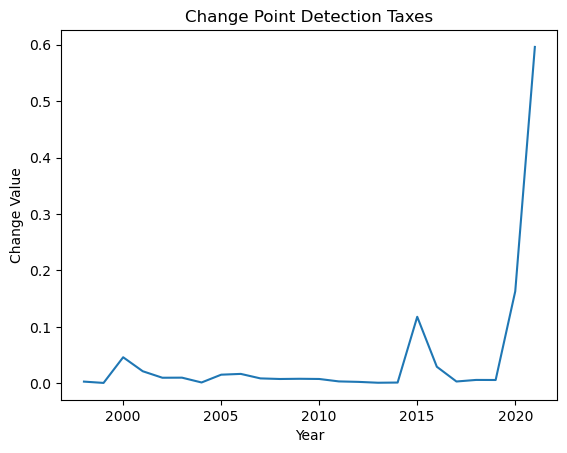

In [74]:
tax_years = []
for key in tax_edge_dict.keys():
    tax_years.append(key)

windowSize = 2
Z_list, year_list = change_point_detection(windowSize, T, tax_years, tax_edge_dict)

fig,ax = plt.subplots()
# Using years var from last cell
ax.plot(year_list, Z_list)
ax.set_title("Change Point Detection Taxes")
ax.set_ylabel("Change Value")
ax.set_xlabel("Year")

plt.show()

### Clustering

In [75]:
taxes_node_mapping = {}

i = 0
for country in taxes["ISO2"].unique():
    taxes_node_mapping[country] = f"u{i}"
    i += 1


j = 0
for policy in taxes["CTS_Code"].unique():
    taxes_node_mapping[policy] = f"i{j}"
    j += 1

inv_taxes_mapping = {v: k for k, v in taxes_node_mapping.items()}

In [76]:
# Create files 
for year in tax_years:
    T.remove_edges_from(T.edges)
    T.add_weighted_edges_from(tax_edge_dict[year])

    T_integer = nx.relabel_nodes(T, taxes_node_mapping)

    fileName = f"BiNE-master/data/taxes/taxes_{year}_edgelist.dat"
    nx.write_weighted_edgelist(T_integer, fileName, delimiter = "\t")

with open("Taxes_commands.txt", "w") as f:
    for year in tax_years:
        command = f"python train.py --train-data ../data/taxes/taxes_{year}_edgelist.dat --lam 0.025 --max-iter 100 --large 2 --vectors-u ../data/taxes/vectors_u_{year}.dat --vectors-v ../data/taxes/vectors_v_{year}.dat &&"
        f.write(command)

# Environmental Protection Expenditures

In [77]:
expenditures = pd.read_csv("input/policy/Environmental_Protection_Expenditures.csv", index_col=0, keep_default_na=False, na_values="")
expenditures.head(5)

,Country,ISO2,ISO3,Indicator,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Unit,F1995,...,F2012,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021
ObjectId,,,,,,,,,,,,,,,,,,,,,
1,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on biodiversity & landscape protec...,"International Monetary Fund (IMF), Statistics ...",GENB_G14,Expenditure on Biodiversity & Landscape Protec...,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,NaN,NaN,NaN,NaN,1.243785e+08,1.258269e+09,NaN,NaN,NaN,NaN
2,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on biodiversity & landscape protec...,"International Monetary Fund (IMF), Statistics ...",GENB_G14,Expenditure on Biodiversity & Landscape Protec...,"Government and Public Sector Finance, Expendit...",Percent of GDP,NaN,...,NaN,NaN,NaN,NaN,9.433491e-03,9.134202e-02,NaN,NaN,NaN,NaN
3,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environment protection,"International Monetary Fund (IMF), Statistics ...",GEN_G14,Environmental Protection Expenditures,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,2.846995e+09,3.344665e+09,2.204964e+09,1.122601e+09,1.702933e+09,2.377937e+09,NaN,NaN,NaN,NaN
4,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environment protection,"International Monetary Fund (IMF), Statistics ...",GEN_G14,Environmental Protection Expenditures,"Government and Public Sector Finance, Expendit...",Percent of GDP,NaN,...,2.754469e-01,2.994793e-01,1.863813e-01,9.152359e-02,1.291590e-01,1.726226e-01,NaN,NaN,NaN,NaN
5,"Afghanistan, Islamic Rep. of",AF,AFG,Expenditure on environmental protection n.e.c.,"International Monetary Fund (IMF), Statistics ...",GENO_G14,Expenditure on Environmental Protection Not El...,"Government and Public Sector Finance, Expendit...",Domestic Currency,NaN,...,NaN,NaN,NaN,NaN,9.669078e+07,8.846917e+07,NaN,NaN,NaN,NaN


In [78]:
exp_country_nodes = expenditures.ISO2.unique()
exp_policy_nodes = expenditures.CTS_Code.unique()
print("Number of countries:", len(country_nodes))
print("Number of expenditures:", len(policy_nodes))

E = nx.Graph()
E.add_nodes_from(country_nodes, bipartite=0)
E.add_nodes_from(policy_nodes, bipartite=1)

Number of countries: 197
Number of expenditures: 21


In [79]:
expenditure_edge_dict = {}

exp_sub = expenditures[expenditures.Unit == "Percent of GDP"]
for year in exp_sub.columns[9:]:
    edge_list = []
    for country in exp_country_nodes:
        subset = exp_sub[exp_sub.ISO2 == country]
        for policy in exp_policy_nodes:
            weight = subset[subset.CTS_Code == policy][year].values
            if weight.size > 0 and weight > 0:
                edge = (country, policy, weight[0])
                edge_list.append(edge)
    expenditure_edge_dict[int(year[1:])] = edge_list
    


In [80]:
print("Number of possible edges:", len(country_nodes) * len(policy_nodes))
print("Number of edges:", len(edges))

Number of possible edges: 4137


NameError: name 'edges' is not defined

### Change Point Detection

<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


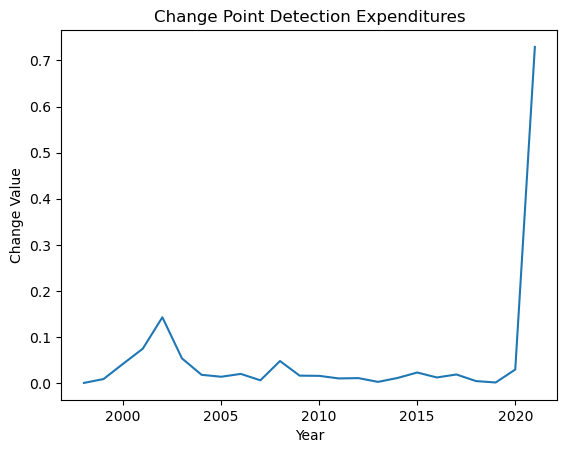

In [81]:
expenditures_years = []
for key in expenditure_edge_dict.keys():
    expenditures_years.append(key)

windowSize = 3
Z_list, year_list = change_point_detection(windowSize, E, expenditures_years, expenditure_edge_dict)


fig,ax = plt.subplots()
# Using years var from last cell
ax.plot(year_list, Z_list)
ax.set_title("Change Point Detection Expenditures")
ax.set_ylabel("Change Value")
ax.set_xlabel("Year")

plt.show()

### Generator for Arbitrary Dataset

Disregard for now. Every dataset requires different pre-processing.

In [ ]:
frame = pd.read_csv('input/policy/Fossil_Fuel_Subsidies.csv', index_col=0, keep_default_na=False, na_values="")
country_nodes = frame.ISO2.unique()
policy_nodes = frame.CTS_Code.unique()
G = nx.Graph()
G.add_nodes_from(country_nodes, bipartite=0)
G.add_nodes_from(policy_nodes, bipartite=1)
years = [int(col[1:]) for col in frame.columns if len(col) == 5 and col[0] == 'F' and col[1:].isdigit()]
index = [i for i in range(len(frame.columns)) if frame.columns[i] == 'F' + str(years[0])][0]

### Analysis

In [82]:
for comp in nx.connected_components(B):
    print(comp)

{'ID', 'PH', 'AT', 'PL', 'ZA', 'JE', 'SE', 'KR', 'AR', 'LU', 'Green Bonds Issuances', 'IS', 'HU', 'DK', 'CA', 'MO', 'GG', 'FI', 'CN', 'JP', 'AU', 'FR', 'RS', 'SK', 'NZ', 'TH', 'CO', 'CZ', 'UA', 'LV', 'MU', 'ES', 'IT', 'PT', 'BR', 'RO', 'KY', 'IL', 'MX', 'DE', 'BE', 'BD', 'IE', 'NL', 'MY', 'IN', 'TR', 'AE', 'BM', 'PK', 'RU', 'VG', 'LI', 'SG', 'GE', 'HK', 'CL', 'TW', 'GR', 'Green Bonds', 'GB', 'US', 'VN', 'NO', 'CH'}
{'CR'}
{'EG'}
{'EE'}
{'FJ'}
{'LT'}
{'MH'}
{'MA'}
{'NA'}
{'NG'}
{'PA'}
{'PE'}
{'SC'}
{'SI'}


In [83]:
G = nx.Graph()
G.add_nodes_from(country_nodes, bipartite=0)
G.add_nodes_from(policy_nodes, bipartite=1)

### IP

In [84]:
from helper import CCNA, IP
print("Running temporal graph...")
obj = CCNA("Environmental_Protection_Expenditures")
print("Temporal Metrics:\n", obj.temporal_metrics())

Running temporal graph...
Temporal Metrics:
     Year  Countries  Edges  Butterflies  Caterpillars     Ratio
0   1995         30    128         2329         11253  0.206967
1   1996         31    132         2592         12216  0.212181
2   1997         31    131         2505         11929  0.209992
3   1998         31    132         2592         12216  0.212181
4   1999         33    133         2481         12078  0.205415
5   2000         38    144         2803         13945  0.201004
6   2001         45    209         6681         31343  0.213158
7   2002         62    230         7271         36119  0.201307
8   2003         61    228         7130         35468  0.201026
9   2004         63    236         7803         38362  0.203404
10  2005         66    251         8974         43766  0.205045
11  2006         69    256         8968         44725  0.200514
12  2007         69    262         9794         47742  0.205144
13  2008         79    286        10795         55031  0.19

In [85]:
print("Building directed graph...")
G = obj.influence_graph()
metrics = {"Nodes": G.number_of_nodes(), "Edges": G.number_of_edges(), "Clustering": nx.average_clustering(G),\
           "Countries": len(obj.countries), "Policies": len(obj.policies)}
print("Directed Graph Values:\n", metrics)

Building directed graph...
Directed Graph Values:
 {'Nodes': 128, 'Edges': 8686, 'Clustering': 0.5832986130944743, 'Countries': 128, 'Policies': 7}


In [86]:
# Initializing IP values
print("Loading graph into IP algorithm...")
ip_obj = IP(G)
print("IP algorithm initialized.")

Loading graph into IP algorithm...
IP algorithm initialized.


/Users/robert/Desktop/CC_NN_Project_Final_Folder/CC_NA/helper.py:190: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = np.zeros((self.N, self.N)) + nx.adjacency_matrix(self.G)


In [87]:
# Computing influence and passivity
M = 20
print("Running", M, "iterations...")
ip_obj.iterate(M)
influence = ip_obj.influence[M - 1]
passivity = ip_obj.passivity[M - 1]

Running 20 iterations...


In [88]:
pd.DataFrame({"Country": ip_obj.countries, "Influence": influence, "Passivity": passivity}).sort_values('Influence', ascending=False).head(10)

,Country,Influence,Passivity
93,KW,0.018743,0.007819
59,IR,0.016657,0.007819
116,OM,0.014529,0.007819
87,BI,0.013079,0.007770
21,BD,0.013011,0.007819
36,DE,0.012502,0.007808
10,KE,0.012423,0.007950
89,EE,0.012332,0.007806
127,ES,0.012248,0.007827
48,AT,0.012248,0.007827


/var/folders/19/6hz5c0tn7g317trnm9tqf_900000gn/T/ipykernel_7817/3167368643.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(y_i))
/var/folders/19/6hz5c0tn7g317trnm9tqf_900000gn/T/ipykernel_7817/3167368643.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(y_p))


Text(0.5, 1.0, 'Convergence of IP Algorithm')

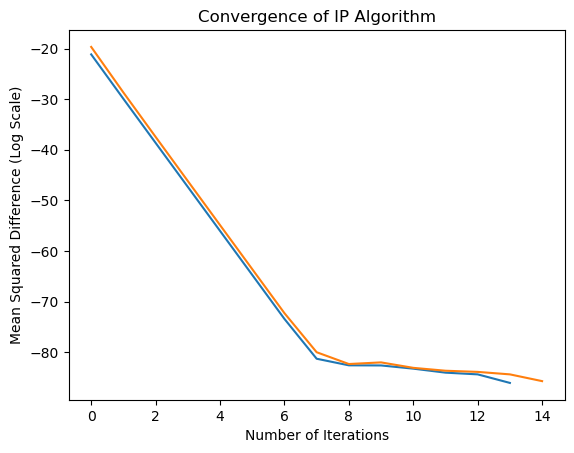

In [89]:
I_diffs = []
P_diffs = []
for m in range(M):
    I_diff = ((ip_obj.influence[m] - influence)**2).mean()
    P_diff = ((ip_obj.passivity[m] - passivity)**2).mean()
    I_diffs.append(I_diff)
    P_diffs.append(P_diff)
x = range(M)
y_i = np.array(I_diffs)
y_p = np.array(P_diffs)
plt.plot(x, np.log(y_i))
plt.plot(x, np.log(y_p))
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Squared Difference (Log Scale)")
plt.title("Convergence of IP Algorithm")

### Clustering

In [90]:
expenditures_node_mapping = {}

i = 0
for country in expenditures["ISO2"].unique():
    expenditures_node_mapping[country] = f"u{i}"
    i += 1


j = 0
for policy in expenditures["CTS_Code"].unique():
    expenditures_node_mapping[policy] = f"i{j}"
    j += 1

inv_taxes_mapping = {v: k for k, v in expenditures_node_mapping.items()}

In [91]:
# Create files 
for year in expenditures_years:
    E.remove_edges_from(E.edges)
    E.add_weighted_edges_from(expenditure_edge_dict[year])

    E_integer = nx.relabel_nodes(E, expenditures_node_mapping)

    fileName = f"BiNE-master/data/expenditures/expenditures_{year}_edgelist.dat"
    nx.write_weighted_edgelist(E_integer, fileName, delimiter = "\t")

# Writes command line prompt to file
with open("Expenditures_commands.txt", "w") as f:
    for year in tax_years:
        command = f"python train.py --train-data ../data/expenditures/expenditures_{year}_edgelist.dat --lam 0.025 --max-iter 100 --large 2 --vectors-u ../data/expenditures/vectors_u_{year}.dat --vectors-v ../data/expenditures/vectors_v_{year}.dat &&"
        f.write(command)